<a href="https://colab.research.google.com/github/hawa1983/SD/blob/main/2024_E_Line_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Total Delay by Delay Type (2024):

1. **Internal Delays Dominate:** Internal delays caused the highest number of train delays in 2024, with **6,624 trains impacted**, indicating significant operational challenges within the system.

2. **External Delays:** External factors led to **4,807 train delays**, making it the second-largest contributor and emphasizing the impact of external disruptions on service reliability.

3. **Planned ROW Work:** Scheduled Right-of-Way (ROW) work resulted in **2,844 train delays**, reflecting the trade-off between necessary maintenance and service interruptions.

4. **Operating Environment:** Issues related to the operating environment caused delays for **2,195 trains**, showcasing the need to address infrastructure and environmental conditions affecting performance.

5. **Crew Availability:** Crew availability issues resulted in **1,934 train delays**, the lowest category, but still a notable area for improvement in workforce management.

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Changes required for a line
# ----------------------------------------------
# Load the dataset
file_path = 'https://raw.githubusercontent.com/hawa1983/SD/refs/heads/main/E_Incident%20List.csv'  # Replace with your file path

# Define train line
train_line = "L"  # Change as needed
train_line = str(train_line)

# ----------------------------------------------

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Ensure 'Line' is consistently string for filtering
data['Line'] = data['Line'].astype(str)
train_line = str(train_line)

# Schedule Rollup
schedule_rollup = "Weekday"

# Interval
start_date = '2024-01-01'
end_date = '2024-12-31'

# ----------------------------------------------

# Delay type
# delay_type = 'Internal'
# data['Delay Type'] = data['Delay Type'].str.strip().str.lower()
delay_type = 'Internal'

/tmp/ipython-input-2274800796.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
/tmp/ipython-input-2274800796.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


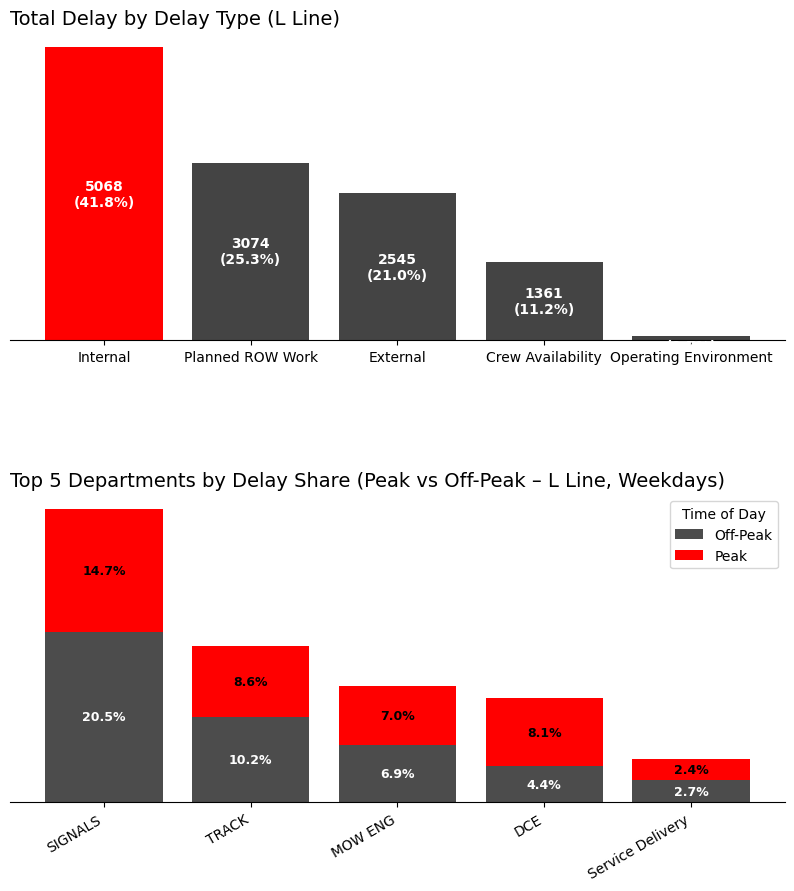

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Required columns check ---
required_cols = {
    'Line', 'Schedule Rollup', 'Delay Type', 'Charge Department',
    'Incident Time', 'Delay Total'
}
missing = required_cols - set(data.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# === 1) Clean & standardize ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])

# === 2) Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === 3) Assign Period and Peak Indicator ===
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)
data['IsPeak'] = data['Period'].isin({'AM Peak', 'PM Peak'})

# === 4) Parameters ===
train_line = "L"
schedule_rollup = "Weekday"

# === 5) Delay Type Plot ===
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce').fillna(0)

filtered_data1 = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup)
]

delay_type_summary = filtered_data1.groupby('Delay Type')['Delay Total'].sum().reset_index()
total_delay1 = filtered_data1['Delay Total'].sum()
delay_type_summary['Percentage'] = (delay_type_summary['Delay Total'] / total_delay1) * 100
delay_type_summary = delay_type_summary.sort_values(by='Delay Total', ascending=False)
delay_type_summary['Color'] = np.where(delay_type_summary['Delay Type'] == "Internal", "#ff0000", "#444444")

# === 6) Full Peak vs Off-Peak Grouping (All Departments) ===
filtered_internal = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup)
]

full_peak_off = (
    filtered_internal
    .groupby(['Charge Department', 'IsPeak'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
    .rename(columns={True: 'Peak', False: 'OffPeak'})
)

# Compute total delay from ALL departments (correct base)
overall_total = full_peak_off[['Peak', 'OffPeak']].to_numpy().sum()
if overall_total == 0:
    raise ValueError("No delay data available.")

# Add shares and total
full_peak_off['PeakShare'] = (full_peak_off['Peak'] / overall_total) * 100
full_peak_off['OffPeakShare'] = (full_peak_off['OffPeak'] / overall_total) * 100
full_peak_off['Total'] = full_peak_off['Peak'] + full_peak_off['OffPeak']
full_peak_off['TotalShare'] = full_peak_off['PeakShare'] + full_peak_off['OffPeakShare']

# === 7) Take Top 5 by Total Delay ===
peak_off = full_peak_off.sort_values('Total', ascending=False).head(5)

# === 8) Plot ===
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), gridspec_kw={'hspace': 0.5})

# --- First Plot: Delay Type ---
bars1 = axes[0].bar(
    delay_type_summary['Delay Type'],
    delay_type_summary['Delay Total'],
    color=delay_type_summary['Color']
)

axes[0].set_title(f"Total Delay by Delay Type ({train_line} Line)", loc='left', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].get_yaxis().set_visible(False)

for bar, value, pct in zip(bars1, delay_type_summary['Delay Total'], delay_type_summary['Percentage']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height/2,
                 f"{int(value)}\n({pct:.1f}%)",
                 ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# --- Second Plot: Top 5 Departments by Peak vs Off-Peak Share ---
x = np.arange(len(peak_off))
off_bars = axes[1].bar(x, peak_off['OffPeakShare'], color='black', alpha=0.7, label='Off-Peak')
peak_bars = axes[1].bar(x, peak_off['PeakShare'], bottom=peak_off['OffPeakShare'], color='red', label='Peak')

for bars in [off_bars, peak_bars]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            y = bar.get_y() + height / 2
            color = 'white' if bar.get_facecolor()[:3] == (0, 0, 0) else 'black'
            axes[1].text(bar.get_x() + bar.get_width()/2,
                         y,
                         f"{height:.1f}%",
                         ha='center', va='center',
                         fontsize=9, fontweight='bold',
                         color=color)

axes[1].set_xticks(x)
axes[1].set_xticklabels(peak_off.index, rotation=30, ha='right')
axes[1].set_title(f"Top 5 Departments by Delay Share (Peak vs Off-Peak – {train_line} Line, Weekdays)", loc='left', fontsize=14)
axes[1].legend(title="Time of Day")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


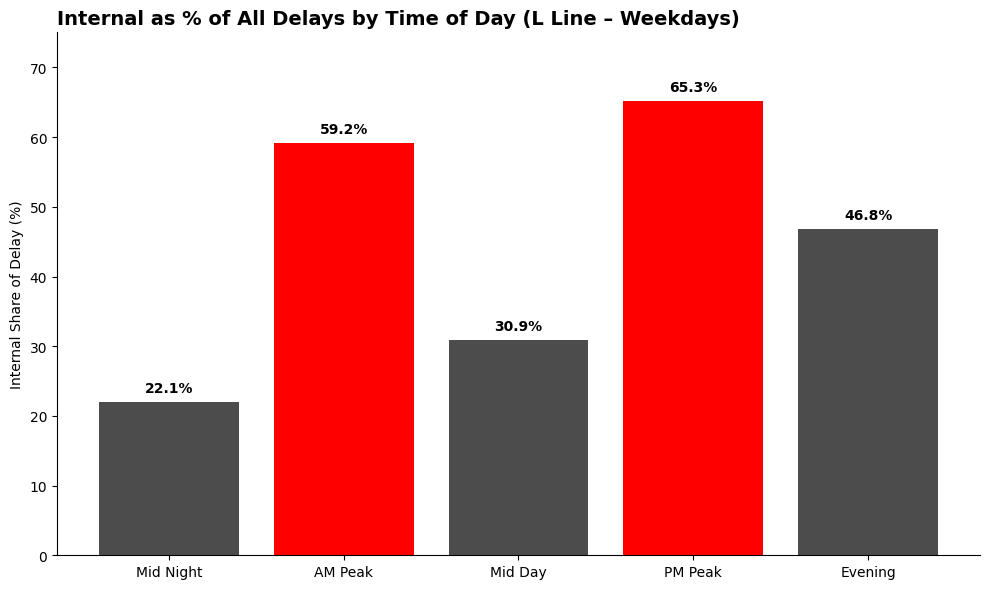

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Clean & Standardize ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()

# Optional mapping (kept for consistency; not required for this calc)
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# Datetime & period assignment
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

def assign_period(hour):
    if 0 <= hour < 6:   return 'Mid Night'
    if 6 <= hour < 10:  return 'AM Peak'
    if 10 <= hour < 15: return 'Mid Day'
    if 15 <= hour < 19: return 'PM Peak'
    if 19 <= hour < 24: return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)

# Numeric delay minutes
data['Delay Total'] = pd.to_numeric(data['Delay Total'], errors='coerce').fillna(0)

# === Filter to line + weekdays only (do NOT filter by Delay Type here) ===
try:
    train_line
    line_label = f"{str(train_line).strip().upper()} Line – "
    mask = (data['Line'] == str(train_line).strip().upper()) & (data['Schedule Rollup'] == 'Weekday')
except NameError:
    line_label = ""
    mask = (data['Schedule Rollup'] == 'Weekday')

base = data.loc[mask].copy()
if base.empty:
    raise ValueError("No data after filtering (line + Weekday).")

# === Totals per period ===
period_order = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
all_delay_by_period = (base.groupby('Period')['Delay Total'].sum()
                       .reindex(period_order).fillna(0))

internal_delay_by_period = (base[base['Delay Type'] == 'Internal']
                            .groupby('Period')['Delay Total'].sum()
                            .reindex(period_order).fillna(0))

# === Share of Internal over All by period (percent) ===
with np.errstate(divide='ignore', invalid='ignore'):
    internal_share_pct = np.where(all_delay_by_period.values > 0,
                                  (internal_delay_by_period.values / all_delay_by_period.values) * 100,
                                  0.0)
internal_share_pct = pd.Series(internal_share_pct, index=period_order)

# === Plot (non-stacked) ===
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if p in {'AM Peak', 'PM Peak'} else 'black' for p in internal_share_pct.index]
alphas = [1.0 if c == 'red' else 0.7 for c in colors]

bars = ax.bar(internal_share_pct.index, internal_share_pct.values, color=colors)
for b, a in zip(bars, alphas):
    b.set_alpha(a)

# Labels
for bar, pct in zip(bars, internal_share_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{pct:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Style
ax.set_title(f"Internal as % of All Delays by Time of Day ({line_label}Weekdays)",
             fontsize=14, fontweight='bold', loc='left')
ax.set_ylabel("Internal Share of Delay (%)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(5, internal_share_pct.max() * 1.15))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


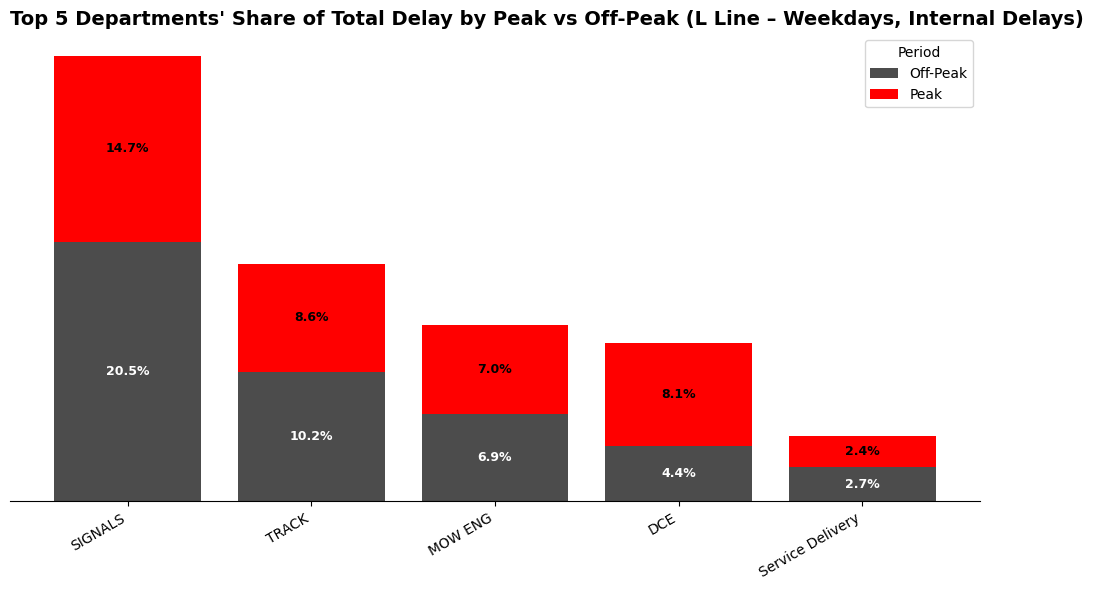

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Required columns check ---
required_cols = {
    'Line', 'Schedule Rollup', 'Delay Type', 'Charge Department',
    'Incident Time', 'Delay Total'
}
missing = required_cols - set(data.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# === 1) Clean & standardize ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()

# === 2) Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === 3) Time & Periods ===
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

def assign_period(hour: float):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)

# === 4) Filters ===
mask = (data['Delay Type'] == 'Internal') & (data['Schedule Rollup'] == 'Weekday')

# Optional: filter by train_line if set
try:
    train_line
    mask &= data['Line'] == str(train_line).strip().upper()
    line_label = f"{str(train_line).strip().upper()} Line – "
except NameError:
    line_label = ""

filtered = data.loc[mask].copy()
filtered['Delay Total'] = pd.to_numeric(filtered['Delay Total'], errors='coerce').fillna(0)

if filtered.empty:
    raise ValueError("No data after filtering.")

# === 5) Peak vs Off-Peak totals per department ===
peak_periods = {'AM Peak', 'PM Peak'}
filtered['IsPeak'] = filtered['Period'].isin(peak_periods)

dept_peak_off = (
    filtered
    .groupby(['Charge Department', 'IsPeak'])['Delay Total']
    .sum()
    .unstack(fill_value=0)
    .rename(columns={True: 'Peak', False: 'OffPeak'})
)

# Overall total delay across all depts
overall_total = dept_peak_off[['Peak', 'OffPeak']].to_numpy().sum()
if overall_total == 0:
    raise ValueError("Overall total delay is zero; cannot compute shares.")

# Convert to share of overall total
dept_peak_off['PeakShareOverall'] = dept_peak_off['Peak'] / overall_total
dept_peak_off['OffPeakShareOverall'] = dept_peak_off['OffPeak'] / overall_total
dept_peak_off['TotalShareOverall'] = dept_peak_off['PeakShareOverall'] + dept_peak_off['OffPeakShareOverall']

# === 6) Take top 5 departments by total share ===
plot_df = (
    dept_peak_off
    .sort_values('TotalShareOverall', ascending=False)
    .head(5)
)

# === 7) Plot stacked bar with centroid annotations ===
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(plot_df))

# Off-Peak (black with alpha=0.7)
off_bars = ax.bar(x, plot_df['OffPeakShareOverall'] * 100,
                  label='Off-Peak', color='black', alpha=0.7)

# Peak (red)
peak_bars = ax.bar(x, plot_df['PeakShareOverall'] * 100,
                   bottom=plot_df['OffPeakShareOverall'] * 100,
                   label='Peak', color='red')

# Annotate centroid of each segment
for bars in [off_bars, peak_bars]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            y = bar.get_y() + height / 2
            ax.text(bar.get_x() + bar.get_width() / 2,
                    y,
                    f"{height:.1f}%",
                    ha='center', va='center',
                    fontsize=9, fontweight='bold',
                    color='white' if bar.get_facecolor()[:3] == (0,0,0) else 'black')

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=30, ha='right')

# Title & legend
ax.set_title(
    f"Top 5 Departments' Share of Total Delay by Peak vs Off-Peak ({line_label}Weekdays, Internal Delays)",
    fontsize=14, fontweight='bold', loc='left'
)
ax.legend(title="Period")

# Remove y-axis
ax.yaxis.set_visible(False)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


/tmp/ipython-input-4283412903.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Delay Total'] = pd.to_numeric(filtered_data['Delay Total'], errors='coerce').fillna(0)


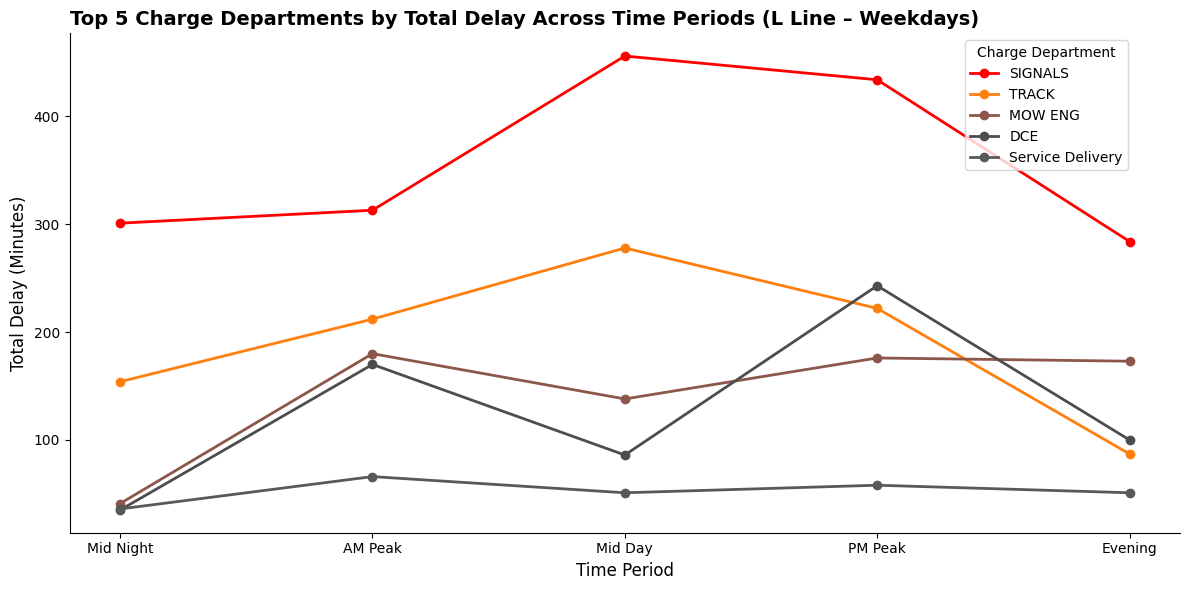

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Clean and Standardize Key Columns ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()

# === Step 2: Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",  # fixed label
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === Step 3: Ensure 'Incident Time' is datetime ===
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])

# Create fractional hour
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Define peak periods
def assign_period(hour):
    if 0.0 <= hour < 6.0:
        return 'Mid Night'
    elif 6.0 <= hour < 10.0:
        return 'AM Peak'
    elif 10.0 <= hour < 15.0:
        return 'Mid Day'
    elif 15.0 <= hour < 19.0:
        return 'PM Peak'
    elif 19.0 <= hour < 24.0:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)

# === Step 4: Filter data ===
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == 'Weekday')
]

# Ensure numeric delay
filtered_data['Delay Total'] = pd.to_numeric(filtered_data['Delay Total'], errors='coerce').fillna(0)

# === Step 5: Group and Prepare for Plot ===
grouped = filtered_data.groupby(['Period', 'Charge Department'])['Delay Total'].sum().unstack(fill_value=0)

# Get top 5 charge departments
top5 = grouped.sum().nlargest(5).index
grouped = grouped[top5]

# Reorder periods
ordered_periods = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
grouped = grouped.reindex(ordered_periods)

# === Step 6: Plot Line Chart ===
custom_colors = ['#ff0000', '#ff7f0e', '#8c564b', '#4d4d4d', '#595959']
fig, ax = plt.subplots(figsize=(12, 6))

for dept, color in zip(grouped.columns, custom_colors):
    ax.plot(grouped.index, grouped[dept], marker='o', label=dept, color=color, linewidth=2)

# Labels & Title
ax.set_title(f"Top 5 Charge Departments by Total Delay Across Time Periods ({train_line} Line – Weekdays)",
             fontsize=14, fontweight='bold', loc='left')
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Total Delay (Minutes)', fontsize=12)
ax.set_xticks(range(len(grouped.index)))
ax.set_xticklabels(grouped.index, rotation=0, fontsize=10)
ax.legend(title='Charge Department', bbox_to_anchor=(0.8, 1), loc='upper left', fontsize=10)

# Remove top/right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


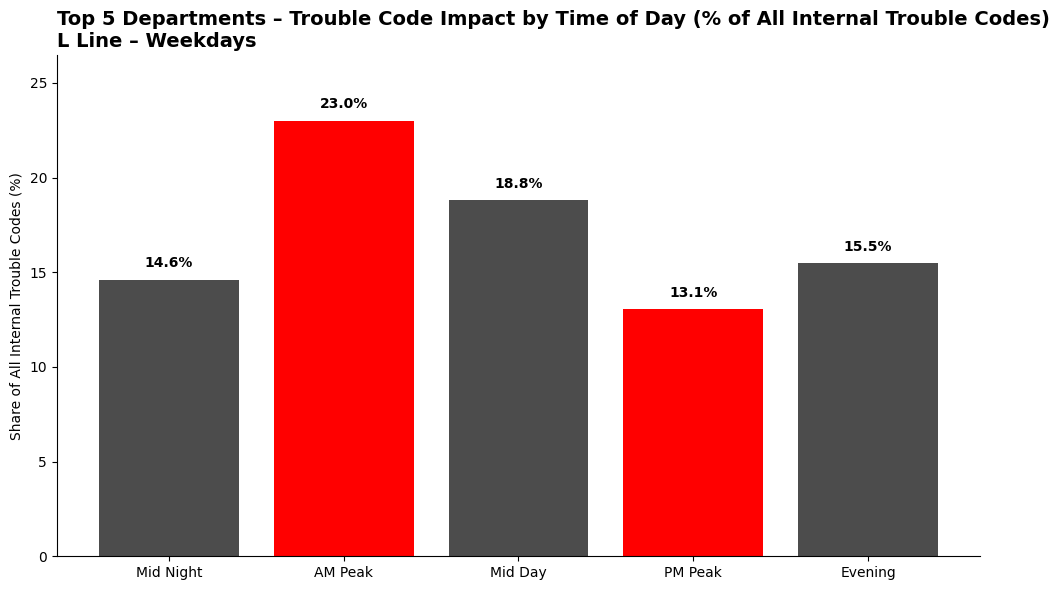

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Clean & Standardize ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()

# === 2) Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === 3) Ensure datetime & assign Period ===
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

def assign_period(hour):
    if 0 <= hour < 6:
        return 'Mid Night'
    elif 6 <= hour < 10:
        return 'AM Peak'
    elif 10 <= hour < 15:
        return 'Mid Day'
    elif 15 <= hour < 19:
        return 'PM Peak'
    elif 19 <= hour < 24:
        return 'Evening'
    return None

data['Period'] = data['FractionalHour'].apply(assign_period)

# === 4) Filter ===
mask = (data['Delay Type'] == 'Internal') & (data['Schedule Rollup'] == 'Weekday')
try:
    train_line
    mask &= data['Line'] == str(train_line).strip().upper()
    line_label = f"{str(train_line).strip().upper()} Line – "
except NameError:
    line_label = ""

filtered = data.loc[mask].copy()
if filtered.empty:
    raise ValueError("No data after filtering.")

# === 5) Get Top 5 Departments by Trouble Code count ===
dept_counts = filtered.groupby('Charge Department')['Trouble Code'].count()
top5_depts = dept_counts.sort_values(ascending=False).head(5).index

# === 6) Aggregate counts for Top 5 by Period ===
period_order = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
top5_period_counts = (
    filtered[filtered['Charge Department'].isin(top5_depts)]
    .groupby('Period')['Trouble Code']
    .count()
    .reindex(period_order)
    .fillna(0)
)

# Total Trouble Codes from ALL departments (denominator)
overall_total_counts = filtered['Trouble Code'].count()

# Percent of total Trouble Codes (all depts)
period_pct = (top5_period_counts / overall_total_counts) * 100

# === 7) Plot ===
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['black' if p not in {'AM Peak', 'PM Peak'} else 'red' for p in period_pct.index]
alphas = [0.7 if c == 'black' else 1.0 for c in colors]

bars = ax.bar(period_pct.index, period_pct.values, color=colors)
for b, a in zip(bars, alphas):
    b.set_alpha(a)

# Annotate bars
for bar, pct in zip(bars, period_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{pct:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels & style
ax.set_title(f"Top 5 Departments – Trouble Code Impact by Time of Day (% of All Internal Trouble Codes)\n{line_label}Weekdays",
             fontsize=14, fontweight='bold', loc='left')
ax.set_ylabel("Share of All Internal Trouble Codes (%)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(5, period_pct.max() * 1.15))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


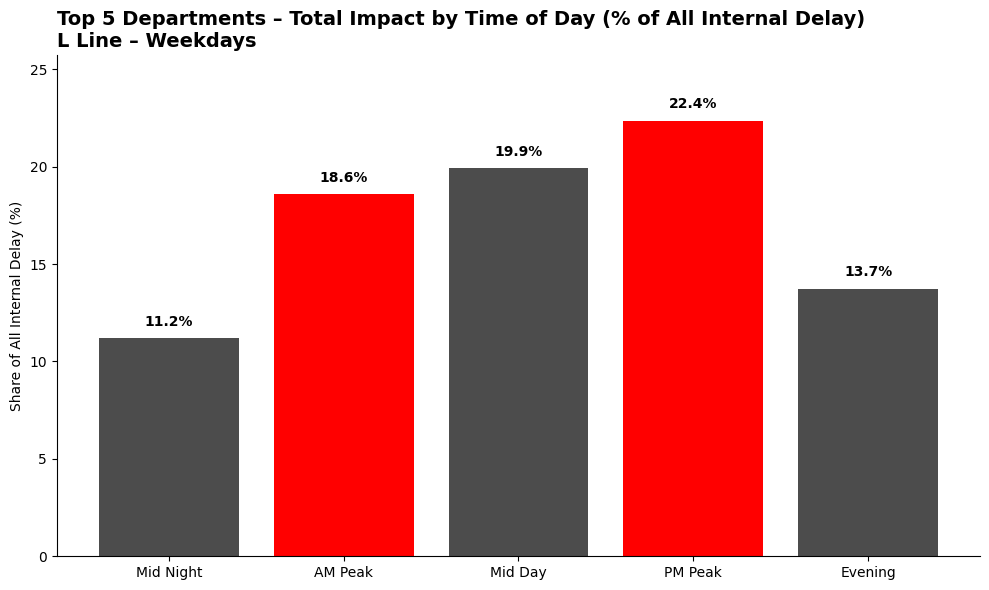

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Clean & Standardize ===
data['Line'] = data['Line'].astype(str).str.strip().str.upper()
data['Schedule Rollup'] = data['Schedule Rollup'].astype(str).str.strip()
data['Delay Type'] = data['Delay Type'].astype(str).str.strip()
data['Charge Department'] = data['Charge Department'].astype(str).str.strip()

# Map Charge Departments
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# Ensure datetime & fractional hour
data['Incident Time'] = pd.to_datetime(data['Incident Time'], errors='coerce')
data = data.dropna(subset=['Incident Time'])
data['FractionalHour'] = data['Incident Time'].dt.hour + data['Incident Time'].dt.minute / 60.0

# Assign periods
def assign_period(hour):
    if 0 <= hour < 6:
        return 'Mid Night'
    elif 6 <= hour < 10:
        return 'AM Peak'
    elif 10 <= hour < 15:
        return 'Mid Day'
    elif 15 <= hour < 19:
        return 'PM Peak'
    elif 19 <= hour < 24:
        return 'Evening'
    return None
data['Period'] = data['FractionalHour'].apply(assign_period)

# Filter: Internal + Weekday + line
mask = (data['Delay Type'] == 'Internal') & (data['Schedule Rollup'] == 'Weekday')
try:
    train_line
    mask &= data['Line'] == str(train_line).strip().upper()
    line_label = f"{str(train_line).strip().upper()} Line – "
except NameError:
    line_label = ""
filtered = data.loc[mask].copy()
filtered['Delay Total'] = pd.to_numeric(filtered['Delay Total'], errors='coerce').fillna(0)

if filtered.empty:
    raise ValueError("No data after filtering.")

# === Get Top 5 Departments ===
dept_totals = filtered.groupby('Charge Department')['Delay Total'].sum()
top5_depts = dept_totals.sort_values(ascending=False).head(5).index

# === Aggregate top 5 depts by Period ===
period_order = ['Mid Night', 'AM Peak', 'Mid Day', 'PM Peak', 'Evening']
top5_period_sums = (
    filtered[filtered['Charge Department'].isin(top5_depts)]
    .groupby('Period')['Delay Total']
    .sum()
    .reindex(period_order)
    .fillna(0)
)

# Total delay from ALL departments (denominator)
overall_total = filtered['Delay Total'].sum()

# Percent of total delay (including all depts)
period_pct = (top5_period_sums / overall_total) * 100

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['black' if p not in {'AM Peak','PM Peak'} else 'red' for p in period_pct.index]
alphas = [0.7 if c == 'black' else 1.0 for c in colors]

bars = ax.bar(period_pct.index, period_pct.values, color=colors)
for b, a in zip(bars, alphas):
    b.set_alpha(a)

# Labels
for bar, pct in zip(bars, period_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{pct:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title(f"Top 5 Departments – Total Impact by Time of Day (% of All Internal Delay)\n{line_label}Weekdays",
             fontsize=14, fontweight='bold', loc='left')
ax.set_ylabel("Share of All Internal Delay (%)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(5, period_pct.max() * 1.15))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


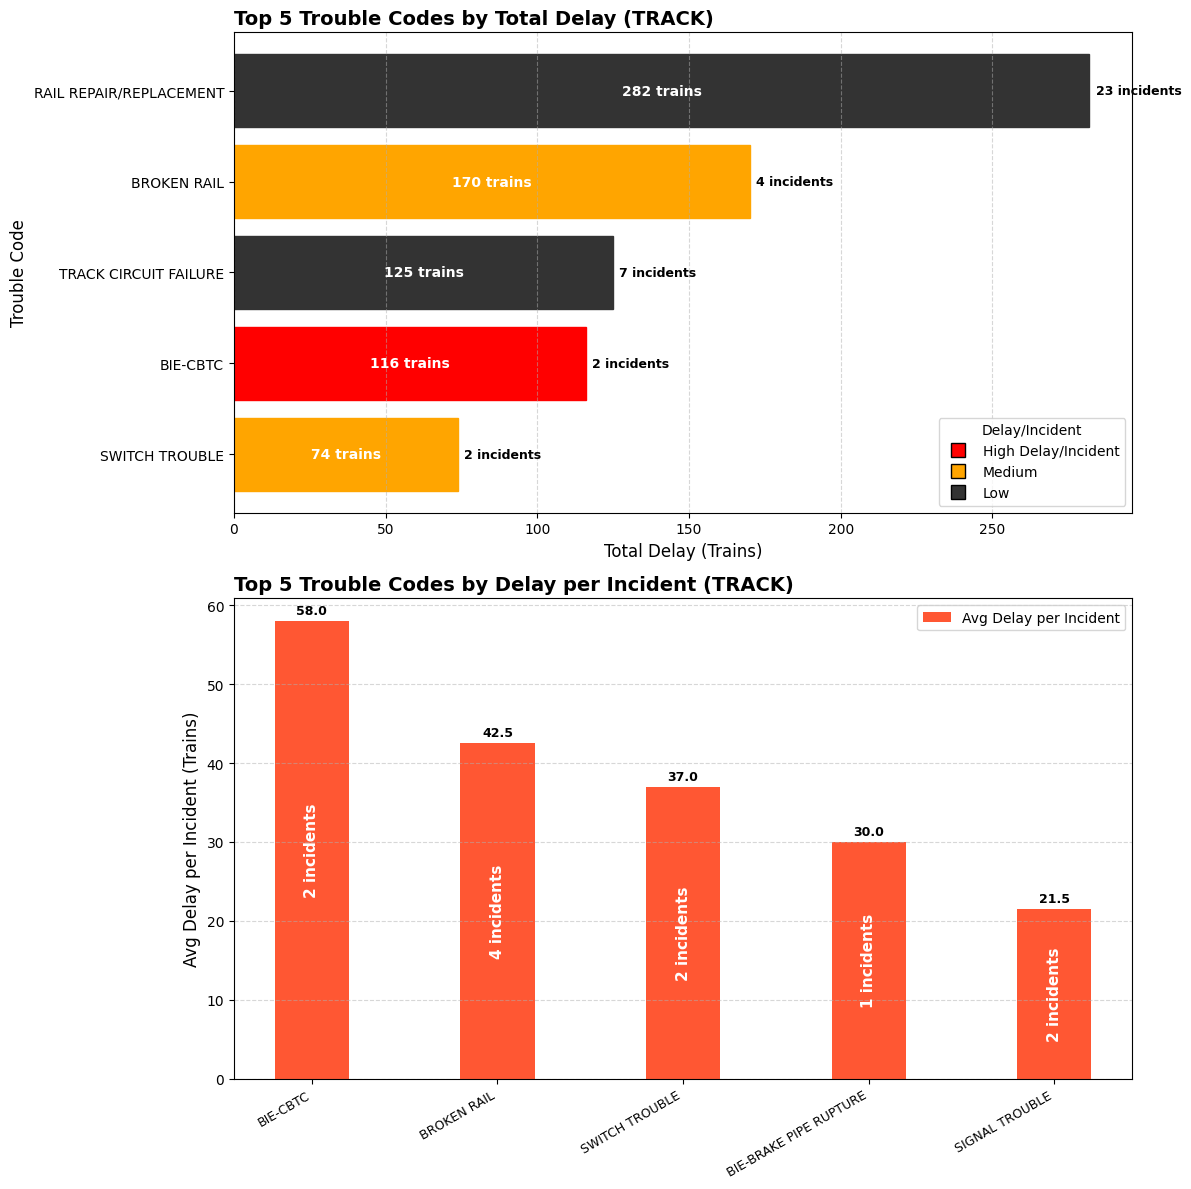

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# === Load your data ===
# data = pd.read_csv('your_file.csv')  # Uncomment and replace with your file path

# === Ensure Date column is datetime ===
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# === Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === Parameters ===
train_line = 'L'
schedule_rollup = 'Weekday'
delay_type = 'Internal'
charge_department = 'TRACK'
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')

# === Filter Data ===
filtered = data[
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Delay Type'] == delay_type) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# === Group Data ===
grouped = filtered.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

grouped['Delay_Per_Incident'] = (grouped['Delay_Total'] / grouped['Incident_Count']).round(1)

# === Top 5 for Each ===
top_total = grouped.nlargest(5, 'Delay_Total').sort_values(by='Delay_Total')
top_delay = grouped.nlargest(5, 'Delay_Per_Incident').sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# === Colors for Total Delay ===
q75 = top_total['Delay_Per_Incident'].quantile(0.75)
q25 = top_total['Delay_Per_Incident'].quantile(0.25)
top_total['Color'] = top_total['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

# === Start Plotting ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# === Chart 1: Total Delay Horizontal Bar ===
bars1 = ax1.barh(
    top_total['Trouble Code'],
    top_total['Delay_Total'],
    color=top_total['Color'],
    edgecolor=top_total['Color']
)
for bar, delay in zip(bars1, top_total['Delay_Total']):
    ax1.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{int(delay)} trains", ha='center', va='center', fontsize=10, fontweight='bold', color='white')

for bar, count in zip(bars1, top_total['Incident_Count']):
    ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
             f"{count} incidents", ha='left', va='center', fontsize=9, color='black', fontweight='bold')

legend_elements = [
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#FF0000', label='High Delay/Incident', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#FFA500', label='Medium', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#333333', label='Low', markersize=10)
]
ax1.legend(handles=legend_elements, title='Delay/Incident', loc='lower right')

ax1.set_title(f"Top 5 Trouble Codes by Total Delay ({charge_department})", loc='left', fontsize=14, fontweight='bold')
ax1.set_xlabel("Total Delay (Trains)", fontsize=12)
ax1.set_ylabel("Trouble Code", fontsize=12)
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# === Chart 2: Delay Per Incident Vertical Bar ===
x = np.arange(len(top_delay))
bars2 = ax2.bar(x, top_delay['Delay_Per_Incident'], width=0.4, color='#FF5733')

ax2.set_ylabel("Avg Delay per Incident (Trains)", fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(top_delay['Trouble Code'], rotation=30, ha='right', fontsize=9)
ax2.set_title(f"Top 5 Trouble Codes by Delay per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')

for i, bar in enumerate(bars2):
    delay = bar.get_height()
    count = top_delay.loc[i, 'Incident_Count']
    ax2.text(bar.get_x() + bar.get_width() / 2, delay + 0.5,
             f"{delay}", ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax2.text(bar.get_x() + bar.get_width() / 2, delay / 2,
             f"{count} incidents", ha='center', va='center', fontsize=11, color='white', fontweight='bold', rotation=90)

ax2.legend(["Avg Delay per Incident"], loc='upper right')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Train Line: L
Schedule Rollup: Weekday
Delay Type: Internal
Charge Department (mapped): TRACK
Date Range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00

Unique 'Line': ['L']
Unique 'Schedule Rollup': ['Weekday']
Unique 'Delay Type': ['Crew Availability' 'External' 'Internal' 'Operating Environment'
 'Planned ROW Work']
Unique 'Charge Department': ['Service Delivery' 'POLICE' 'TRACK' 'PUBLIC' 'SIGNALS' 'MTA C&D'
 'MOW ENG' 'OPS TRAIN' 'WEATHER' 'OPS PLANN' 'MOW POWER' 'DCE' 'MISC'
 'MOW INF' 'EMD' 'ATS' 'PUBLIC WORKS' 'MTA-IT']
Date range in data: 2024-01-02 00:00:00 to 2024-12-31 00:00:00

Filtered Data Count: 52
          Date Schedule Rollup STARS ID                  Station Unique  \
4   2024-01-02         Weekday     B-39      14 St - Union Square (L03)   
21  2024-01-04         Weekday      B-9      14 St - Union Square (L03)   
58  2024-01-11         Weekday     B-27                 Graham Av (L11)   
114 2024-01-22         Weekday      B-3                Lorimer St (L10)   
139 202

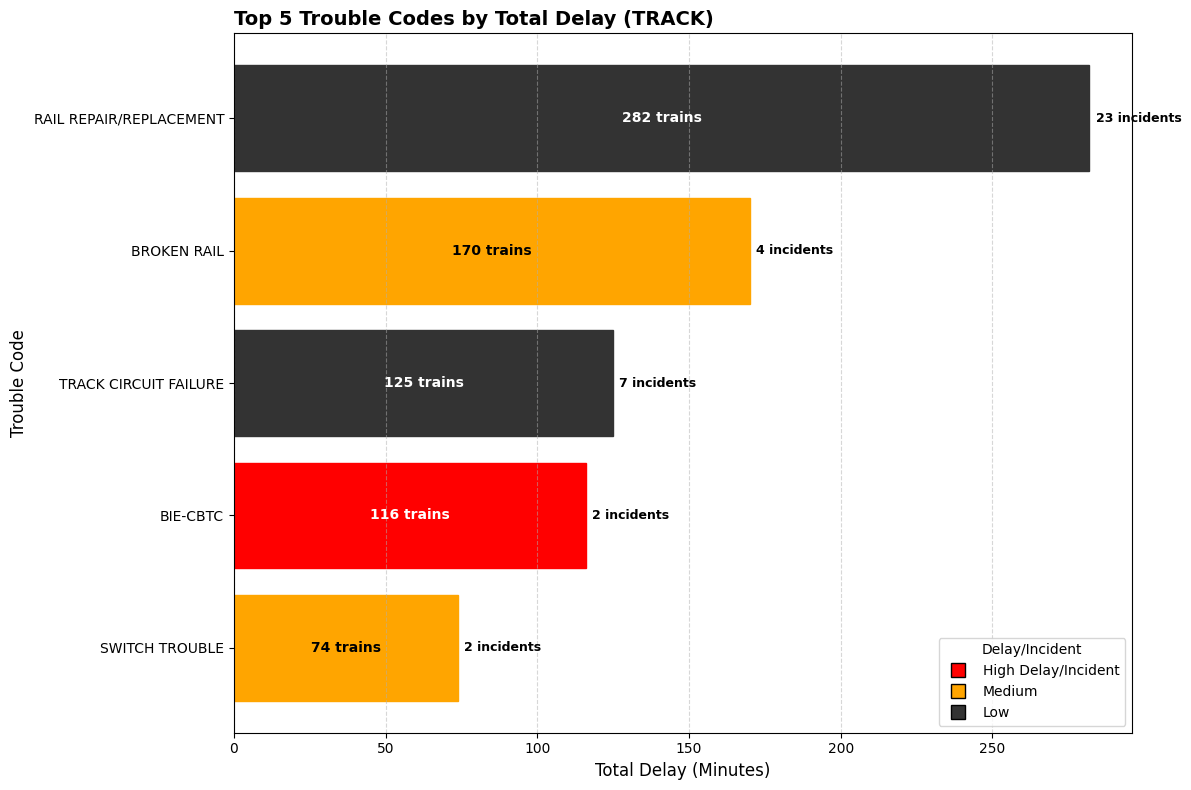

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# === Load your CSV ===
# data = pd.read_csv('your_file.csv')  # Uncomment and replace with actual file path

# === Ensure 'Date' column is datetime ===
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# === Map Charge Departments ===
charge_dept_mapping = {
    "Division of Service Delivery": "Service Delivery",
    "Police": "POLICE",
    "Division of MOW Track": "TRACK",
    "Public": "PUBLIC",
    "Division of MOW Signals": "SIGNALS",
    "Division of Car Equipment": "DCE",
    "OPS Training": "OPS TRAIN",
    "Division of MOW Engineering": "MOW ENG",
    "MTA Construction & Development": "MTA C&D",
    "Miscellaneous": "MISC",
    "Division of MOW Infrastructure": "MOW INF",
    "Division of Electrical Maintenance": "EMD",
    "Operations Planning": "OPS PLANN",
    "Automatic Train Supervision": "ATS",
    "Division of MOW Power": "MOW POWER",
    "MTA-IT": "MTA-IT",
    "Weather": "WEATHER",
    "Public Works and Utility": "PUBLIC WORKS"
}
data['Charge Department'] = data['Charge Department'].map(charge_dept_mapping).fillna(data['Charge Department'])

# === Parameters (set these before running) ===
train_line = 'L'
schedule_rollup = 'Weekday'
delay_type = 'Internal'
charge_department = 'TRACK'
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')

# === DEBUG: Show filtering values ===
print("Train Line:", train_line)
print("Schedule Rollup:", schedule_rollup)
print("Delay Type:", delay_type)
print("Charge Department (mapped):", charge_department)
print("Date Range:", start_date, "to", end_date)

# === DEBUG: Unique values for troubleshooting ===
print("\nUnique 'Line':", data['Line'].unique())
print("Unique 'Schedule Rollup':", data['Schedule Rollup'].unique())
print("Unique 'Delay Type':", data['Delay Type'].unique())
print("Unique 'Charge Department':", data['Charge Department'].unique())
print("Date range in data:", data['Date'].min(), "to", data['Date'].max())

# === Filter the data ===
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# === DEBUG: Filtered result ===
print("\nFiltered Data Count:", len(filtered_data))
if filtered_data.empty:
    print("Filtered data is empty. Check input filters.")
else:
    print(filtered_data.head())

# === Group by Trouble Code ===
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

if trouble_code_data.empty:
    print("No trouble code data available.")
else:
    print("\nTop Trouble Codes:\n", trouble_code_data.sort_values(by='Delay_Total', ascending=False).head())

# === Calculate Delay Per Incident ===
trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']

# === Select Top 5 by Total Delay ===
top_5 = trouble_code_data.nlargest(5, 'Delay_Total').copy()

# === Assign Colors by Delay/Incident Tiers ===
q75 = top_5['Delay_Per_Incident'].quantile(0.75)
q25 = top_5['Delay_Per_Incident'].quantile(0.25)

top_5['Color'] = top_5['Delay_Per_Incident'].apply(
    lambda x: '#FF0000' if x > q75 else ('#FFA500' if x > q25 else '#333333')
)

top_5 = top_5.sort_values(by='Delay_Total', ascending=True)

# === Plot ===
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_5['Trouble Code'],
    top_5['Delay_Total'],
    color=top_5['Color'],
    edgecolor=top_5['Color']
)

# === Annotate Bars ===
for bar, delay in zip(bars, top_5['Delay_Total']):
    x = bar.get_width() / 2
    y = bar.get_y() + bar.get_height() / 2
    r, g, b = bar.get_facecolor()[:3]
    brightness = r * 0.299 + g * 0.587 + b * 0.114
    text_color = 'white' if brightness < 0.5 else 'black'
    plt.text(x, y, f"{int(delay)} trains", ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)

for bar, count in zip(bars, top_5['Incident_Count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(x + 2, y, f"{count} incidents", ha='left', va='center', fontsize=9, color='black', fontweight='bold')

# === Custom Legend ===
legend_elements = [
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#FF0000', label='High Delay/Incident', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#FFA500', label='Medium', markersize=10),
    Line2D([0], [0], marker='s', color='none', markerfacecolor='#333333', label='Low', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident', loc='lower right')

# === Layout ===
plt.title(f"Top 5 Trouble Codes by Total Delay ({charge_department})", loc='left', fontsize=14, fontweight='bold')
plt.xlabel("Total Delay (Minutes)", fontsize=12)
plt.ylabel("Trouble Code", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


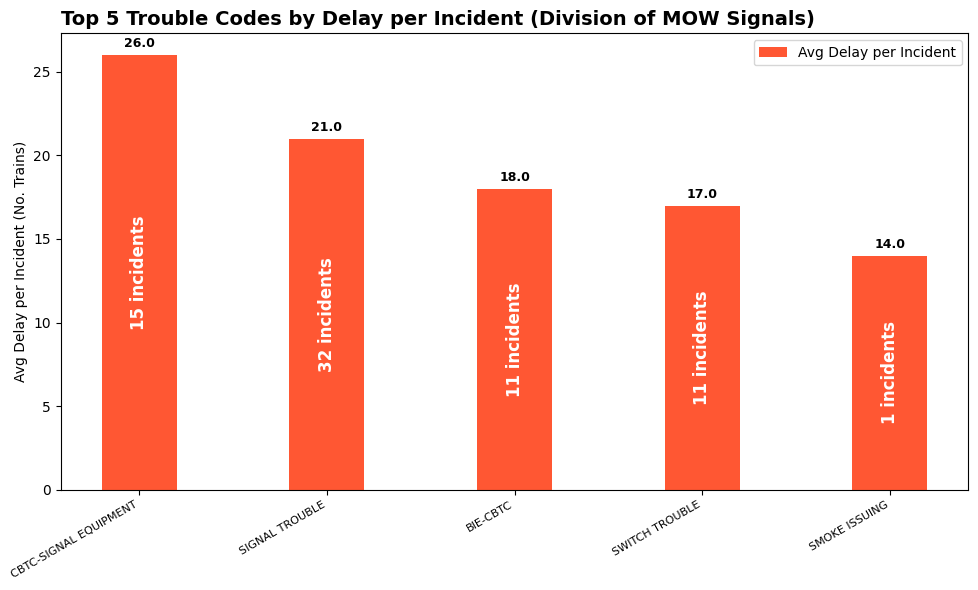

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the file
data = pd.read_csv(file_path)

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# ----------------------------------------------
charge_department = 'Division of MOW Signals'

# --- Filter the Data ---
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department) &
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# --- Group and Calculate Metrics ---
trouble_code_data = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

# trouble_code_data['Delay_Per_Incident'] = trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
trouble_code_data['Delay_Per_Incident'] = (
    trouble_code_data['Delay_Total'] / trouble_code_data['Incident_Count']
).round().astype(int)



# --- Prepare Top 5 by Delay per Incident ---
top5 = trouble_code_data.nlargest(5, 'Delay_Per_Incident').copy()
top5 = top5.sort_values(by='Delay_Per_Incident', ascending=False).reset_index(drop=True)

# --- Plot ---
x = np.arange(len(top5))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar: Avg Delay per Incident
bars1 = ax1.bar(x, top5['Delay_Per_Incident'], width, label='Avg Delay per Incident', color='#FF5733')
ax1.set_ylabel("Avg Delay per Incident (No. Trains)")
ax1.set_xticks(x)
ax1.set_xticklabels(top5['Trouble Code'], rotation=30, ha='right', fontsize=8)
ax1.set_title(f"Top 5 Trouble Codes by Delay per Incident ({charge_department})", loc='left', fontsize=14, fontweight='bold')

# Annotate each bar with:
# (1) Avg delay
# (2) Incident count below or inside the bar
for i, bar in enumerate(bars1):
    delay = bar.get_height()
    count = top5.loc[i, 'Incident_Count']

    # Avg Delay (on top)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay + 0.3,
             f"{delay:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Incident Count (inside or below the bar)
    ax1.text(bar.get_x() + bar.get_width() / 2, delay / 2,
             f"{count} incidents", ha='center', va='center', fontsize=12, color='white', fontweight='bold', rotation=90)

# Legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

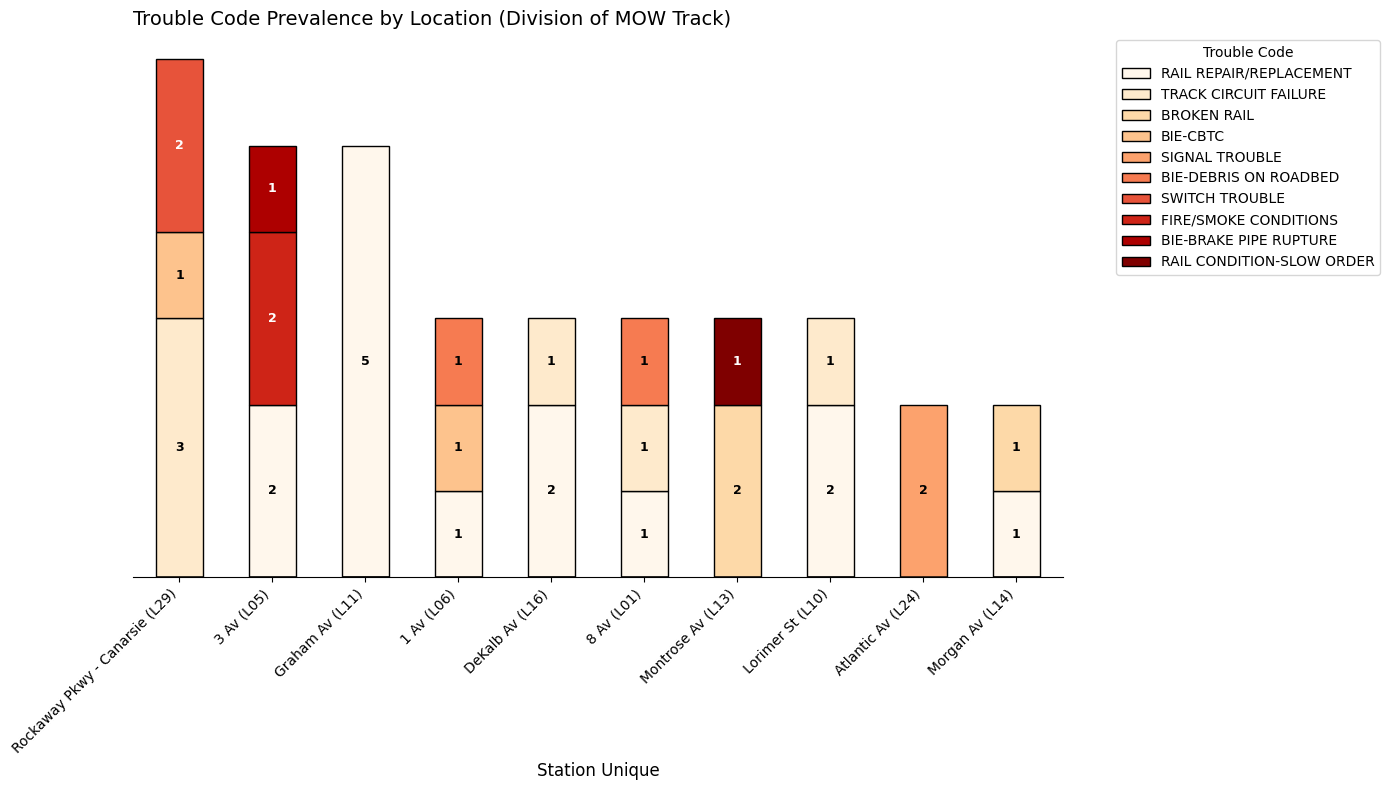


Most Frequent Trouble Codes Across All Locations:
                        Count  count
0     RAIL REPAIR/REPLACEMENT     23
1       TRACK CIRCUIT FAILURE      7
2       BIE-DEBRIS ON ROADBED      5
3                 BROKEN RAIL      4
4       FIRE/SMOKE CONDITIONS      4
5              SWITCH TROUBLE      2
6                    BIE-CBTC      2
7              SIGNAL TROUBLE      2
8   RAIL CONDITION-SLOW ORDER      1
9      BIE-BRAKE PIPE RUPTURE      1
10             SPARKS ISSUING      1

Hot Spots (Stations with Multiple or High-Impact Trouble Codes):
                    Station Unique  Unique Trouble Codes  Total Troubles
20  Rockaway Pkwy - Canarsie (L29)                     3               6
2                       3 Av (L05)                     3               5
11                 Graham Av (L11)                     1               5
0                       1 Av (L06)                     3               3
17               Montrose Av (L13)                     2               3
5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Parameters ===
train_line = "L"
schedule_rollup = "Weekday"
charge_department = 'Division of MOW Track'

# === 1) Filter Relevant Data ===
filtered_data = data[
    (data['Delay Type'] == 'Internal') &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# === 2) Identify Top Stations ===
top_stations = (
    filtered_data.groupby('Station Unique')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

# === 3) Group by Trouble Code and Station (Keep all codes) ===
stacked_data = (
    filtered_data[filtered_data['Station Unique'].isin(top_stations)]
    .groupby(['Station Unique', 'Trouble Code'])
    .size()
    .unstack(fill_value=0)
)

# Sort by totals
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]
stacked_data = stacked_data.loc[:, stacked_data.sum(axis=0).sort_values(ascending=False).index]

# === 4) Plot Stacked Bar Chart ===
plt.figure(figsize=(14, 8))
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='OrRd', edgecolor='black')

# Add annotations
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        bar_color = bar.get_facecolor()
        r, g, b, _ = mcolors.to_rgba(bar_color)
        brightness = r * 0.299 + g * 0.587 + b * 0.114
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(x, y, int(height), ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

# Customize layout
plt.title(f'Trouble Code Prevalence by Location ({charge_department})', fontsize=14, loc='left')
plt.xlabel('Station Unique', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Trouble Code', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# === 5) Debug Output – Most Frequent Trouble Codes (All Locations) ===
code_counts = (
    filtered_data['Trouble Code']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Trouble Code', 'Trouble Code': 'Count'})
)
print("\nMost Frequent Trouble Codes Across All Locations:")
print(code_counts)

# === 6) Debug Output – Hot Spot Detection ===
trouble_by_station = (
    filtered_data.groupby('Station Unique')['Trouble Code']
    .nunique()
    .reset_index()
    .rename(columns={'Trouble Code': 'Unique Trouble Codes'})
)

total_troubles = (
    filtered_data.groupby('Station Unique')
    .size()
    .reset_index(name='Total Troubles')
)

hotspots = pd.merge(trouble_by_station, total_troubles, on='Station Unique')

hotspots_filtered = hotspots[
    (hotspots['Unique Trouble Codes'] >= 2) | (hotspots['Total Troubles'] >= 3)
].sort_values(by='Total Troubles', ascending=False)

print("\nHot Spots (Stations with Multiple or High-Impact Trouble Codes):")
print(hotspots_filtered)

Summary of Trouble Codes – Division of Car Equipment (L Line – Weekday):
                     Trouble Code  Total Delay (min)  Incident Count  \
29                   STUCK BRAKES                127              19   
7                        BIE-CBTC                 46               8   
23                 NO MOTOR POWER                 58               7   
13             CBTC-CAR EQUIPMENT                 39               6   
10          BRAKES FAIL TO CHARGE                  8               5   
19            GUARD LIGHT TROUBLE                 43               5   
2                 B/O P.A./BUZZER                 25               4   
27                     SLOW TRAIN                 35               3   
3          B/O T/O CONSOLE SWITCH                  2               2   
17        DRS FAIL TO O/C SECTION                  5               2   
16            DRS FAIL TO O/C CAR                  5               2   
20         LOSS OF C/R INDICATION                 14           

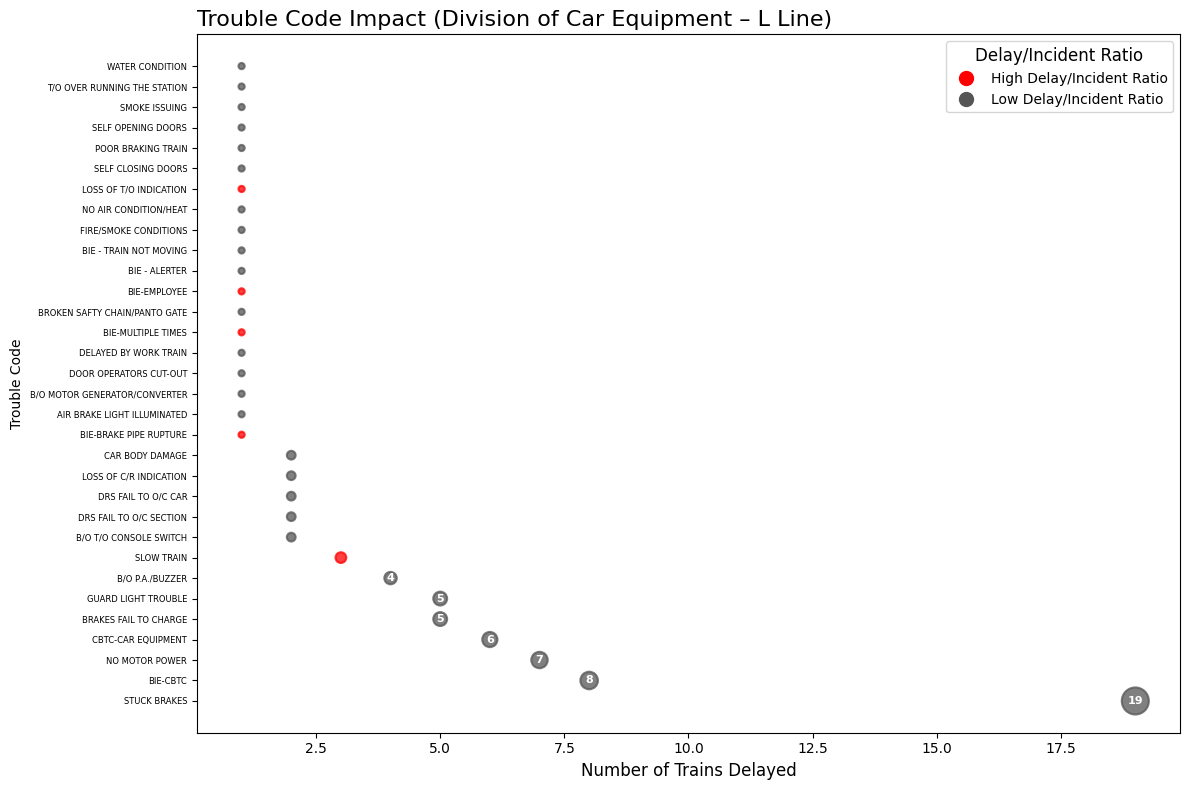

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Parameters ===
charge_department = 'Division of Car Equipment'
train_line = 'L'
schedule_rollup = 'Weekday'
delay_type = 'Internal'

# === 1) Filter the Data ===
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# === 2) Summarize Trouble Codes ===
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Total_Delay_Min=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

# === 3) Calculate Delay per Incident ===
trouble_code_summary['Avg_Delay_per_Incident'] = (
    trouble_code_summary['Total_Delay_Min'] / trouble_code_summary['Incident_Count']
)

# === 4) Compute Threshold ===
threshold_ratio = trouble_code_summary['Avg_Delay_per_Incident'].mean()
trouble_code_summary['High Impact'] = trouble_code_summary['Avg_Delay_per_Incident'] > threshold_ratio

# === 5) Format & Sort ===
trouble_code_summary = trouble_code_summary.sort_values(by='Incident_Count', ascending=False)
trouble_code_summary['Total_Delay_Min'] = trouble_code_summary['Total_Delay_Min'].round(1)
trouble_code_summary['Avg_Delay_per_Incident'] = trouble_code_summary['Avg_Delay_per_Incident'].round(1)
trouble_code_summary = trouble_code_summary.rename(columns={
    'Trouble Code': 'Trouble Code',
    'Total_Delay_Min': 'Total Delay (min)',
    'Incident_Count': 'Incident Count',
    'Avg_Delay_per_Incident': 'Avg Delay per Incident'
})

# === 6) Save Results ===
trouble_code_summary.to_excel("Trouble_Code_Impact_DCE_L_Line.xlsx", index=False)
trouble_code_summary.to_csv("Trouble_Code_Impact_DCE_L_Line.csv", index=False)

# === 7) Print Summary ===
print("Summary of Trouble Codes – Division of Car Equipment (L Line – Weekday):")
print(trouble_code_summary)

print("\nConcise Analysis\n")
most_frequent = trouble_code_summary.iloc[0]
print(f"Most frequent trouble code: {most_frequent['Trouble Code']}")
print(f"- Occurred {most_frequent['Incident Count']} times")
print(f"- Caused {most_frequent['Total Delay (min)']} minutes of delay")
print(f"- Average delay per incident: {most_frequent['Avg Delay per Incident']} minutes\n")

print("High-Impact Trouble Codes (Avg Delay > Mean):")
high_impact_codes = trouble_code_summary[trouble_code_summary['High Impact']]
for _, row in high_impact_codes.iterrows():
    print(f"- {row['Trouble Code']}: {row['Avg Delay per Incident']} min/incident "
          f"over {row['Incident Count']} incidents "
          f"({row['Total Delay (min)']} min total)")

# === 8) Bubble Plot (X = Incident Count) ===
colors = ['#ff0000' if hi else '#555555' for hi in trouble_code_summary['High Impact']]
edge_colors = colors
bubble_size = trouble_code_summary['Incident Count'] * 20

plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Incident Count'],
    trouble_code_summary['Trouble Code'],
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75
)

# Annotate bubbles where incident count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Incident Count'] > 3:
        plt.text(
            row['Incident Count'],
            row['Trouble Code'],
            str(row['Incident Count']),
            fontsize=8,
            ha='center',
            va='center',
            color='white',
            weight='bold'
        )

plt.title(f'Trouble Code Impact ({charge_department} – {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Number of Trains Delayed', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)
plt.yticks(fontsize=6)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio',
           markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio',
           markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()


Summary of Trouble Codes – Division of Car Equipment (L Line – Weekday):
                     Trouble Code  Total Delay (min)  Delayed Trains (count)  \
29                   STUCK BRAKES                127                      19   
8                    BIE-EMPLOYEE                101                       1   
23                 NO MOTOR POWER                 58                       7   
7                        BIE-CBTC                 46                       8   
19            GUARD LIGHT TROUBLE                 43                       5   
13             CBTC-CAR EQUIPMENT                 39                       6   
6          BIE-BRAKE PIPE RUPTURE                 37                       1   
27                     SLOW TRAIN                 35                       3   
2                 B/O P.A./BUZZER                 25                       4   
9              BIE-MULTIPLE TIMES                 20                       1   
21         LOSS OF T/O INDICATION              

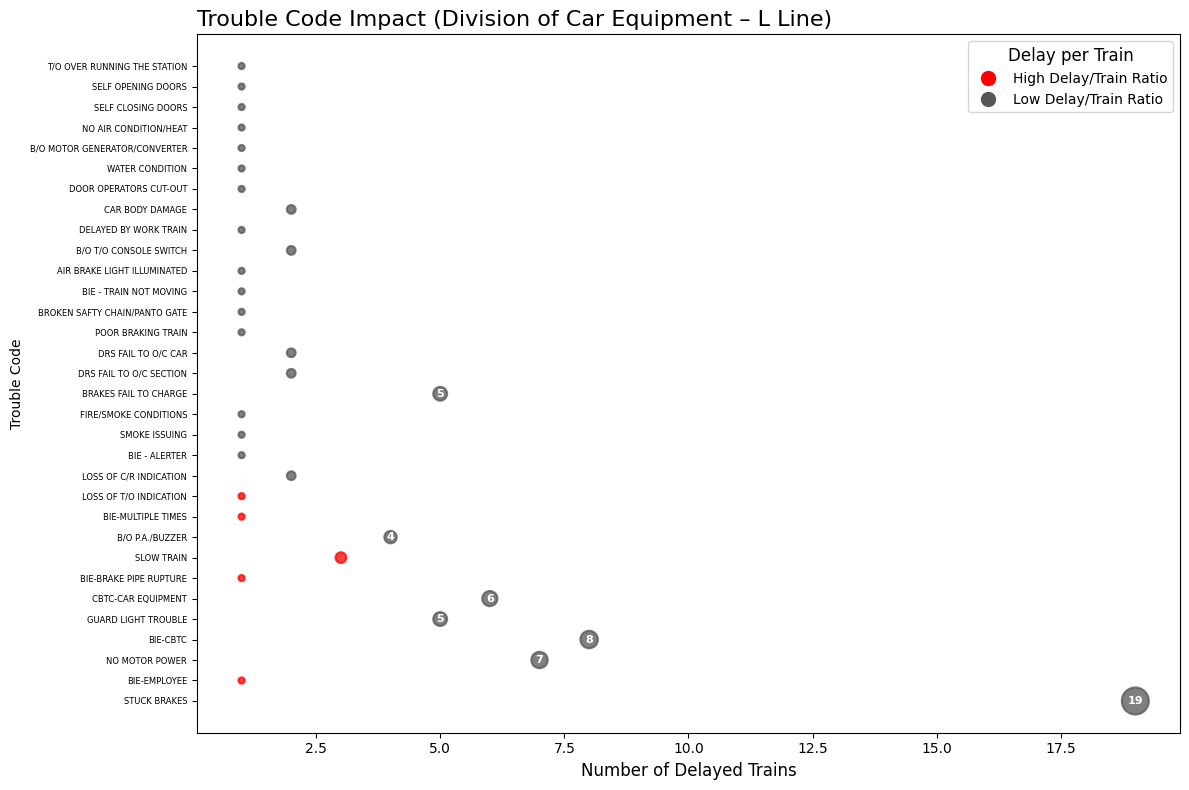

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Parameters ===
charge_department = 'Division of Car Equipment'
train_line = 'L'
schedule_rollup = 'Weekday'
delay_type = 'Internal'

# === 1) Filter the Data ===
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# === 2) Summarize Trouble Codes ===
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Total_Delay_Min=('Delay Total', 'sum'),
    Incident_Count=('Trouble Code', 'count')
).reset_index()

# === 3) Calculate Delay per Incident ===
trouble_code_summary['Avg_Delay_per_Incident'] = (
    trouble_code_summary['Total_Delay_Min'] / trouble_code_summary['Incident_Count']
)

# === 4) Compute Threshold ===
threshold_ratio = trouble_code_summary['Avg_Delay_per_Incident'].mean()
trouble_code_summary['High Impact'] = trouble_code_summary['Avg_Delay_per_Incident'] > threshold_ratio

# === 5) Format & Sort ===
trouble_code_summary = trouble_code_summary.sort_values(by='Total_Delay_Min', ascending=False)
trouble_code_summary['Total_Delay_Min'] = trouble_code_summary['Total_Delay_Min'].round(1)
trouble_code_summary['Avg_Delay_per_Incident'] = trouble_code_summary['Avg_Delay_per_Incident'].round(1)
trouble_code_summary = trouble_code_summary.rename(columns={
    'Trouble Code': 'Trouble Code',
    'Total_Delay_Min': 'Total Delay (min)',
    'Incident_Count': 'Delayed Trains (count)',
    'Avg_Delay_per_Incident': 'Avg Delay per Train (min)'
})

# === 6) Save Results ===
trouble_code_summary.to_excel("Trouble_Code_Impact_DCE_L_Line.xlsx", index=False)
trouble_code_summary.to_csv("Trouble_Code_Impact_DCE_L_Line.csv", index=False)

# === 7) Print Summary ===
print("Summary of Trouble Codes – Division of Car Equipment (L Line – Weekday):")
print(trouble_code_summary)

print("\nConcise Analysis\n")

most_frequent = trouble_code_summary.iloc[0]
print(f"Most frequent trouble code: {most_frequent['Trouble Code']}")
print(f"- Affected {most_frequent['Delayed Trains (count)']} trains")
print(f"- Total delay: {most_frequent['Total Delay (min)']} minutes")
print(f"- Average delay per train: {most_frequent['Avg Delay per Train (min)']} minutes\n")

print("High-Impact Trouble Codes (Avg Delay > Mean):")
high_impact_codes = trouble_code_summary[trouble_code_summary['High Impact']]
for _, row in high_impact_codes.iterrows():
    print(f"- {row['Trouble Code']}: {row['Avg Delay per Train (min)']} min/train "
          f"across {row['Delayed Trains (count)']} trains "
          f"({row['Total Delay (min)']} min total)")

# === 8) Bubble Plot ===
colors = ['#ff0000' if hi else '#555555' for hi in trouble_code_summary['High Impact']]
edge_colors = colors
bubble_size = trouble_code_summary['Delayed Trains (count)'] * 20

plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delayed Trains (count)'],
    trouble_code_summary['Trouble Code'],
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75
)

# Annotate bubbles where incident count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Delayed Trains (count)'] > 3:
        plt.text(
            row['Delayed Trains (count)'],
            row['Trouble Code'],
            str(row['Delayed Trains (count)']),
            fontsize=8,
            ha='center',
            va='center',
            color='white',
            weight='bold'
        )

plt.title(f'Trouble Code Impact ({charge_department} – {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Number of Delayed Trains', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)
plt.yticks(fontsize=6)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Train Ratio',
           markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Train Ratio',
           markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay per Train', loc='upper right', fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()


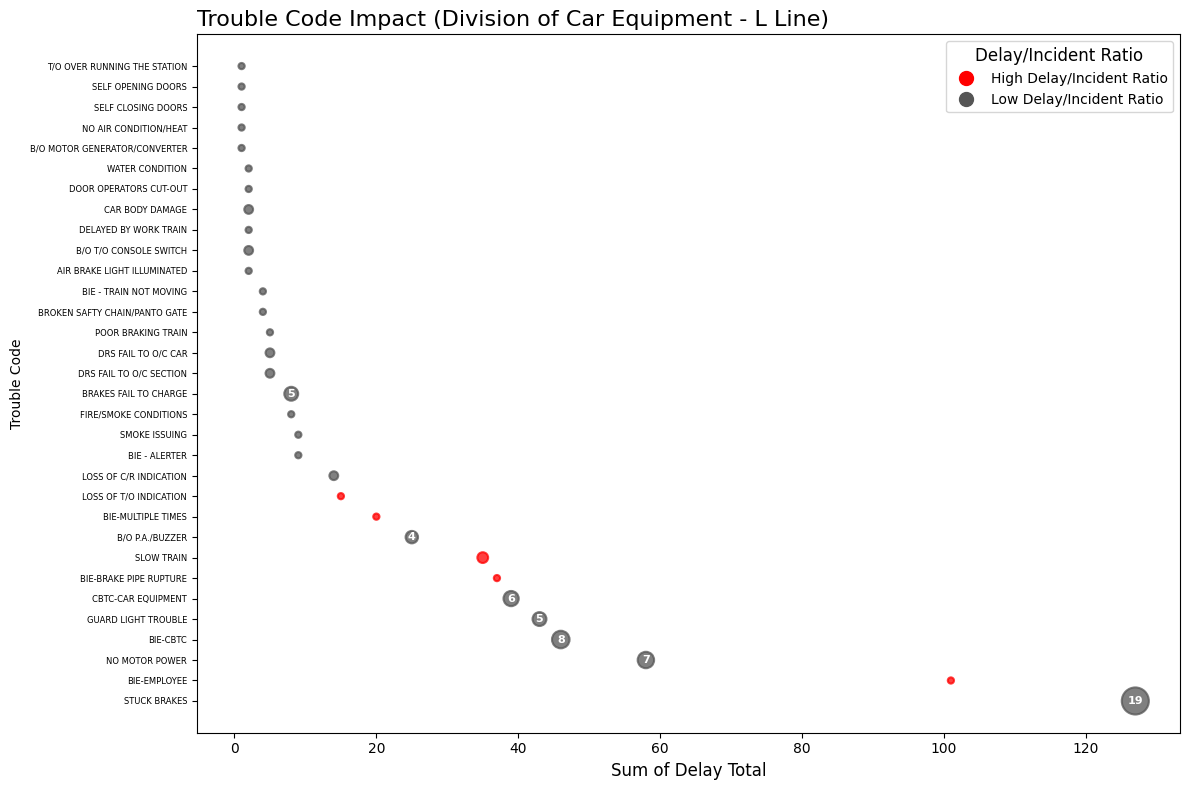

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

charge_department = 'Division of Car Equipment'

# Filter the data for the specified conditions
filtered_data = data[
    (data['Delay Type'] == delay_type) &
    (data['Line'] == train_line) &
    (data['Schedule Rollup'] == schedule_rollup) &
    (data['Charge Department'] == charge_department)
]

# Group the data by 'Trouble Code' to calculate the sum of 'Delay Total' and count of 'Trouble Code'
trouble_code_summary = filtered_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Calculate the ratio of Delay Total to Trouble Count
trouble_code_summary['Delay_Ratio'] = trouble_code_summary['Delay_Total'] / trouble_code_summary['Trouble_Count']

# Sort the data by Total Delay in descending order
trouble_code_summary = trouble_code_summary.sort_values(by='Delay_Total', ascending=False)

# Determine colors: Highlight high-ratio points
threshold_ratio = trouble_code_summary['Delay_Ratio'].mean()  # Set threshold as the mean ratio
colors = ['#ff0000' if ratio > threshold_ratio else '#555555'
          for ratio in trouble_code_summary['Delay_Ratio']]

# Set edge colors: Red for high-ratio points, default for others
edge_colors = ['#ff0000' if color == '#ff0000' else '#555555' for color in colors]

# Set bubble size proportional to Trouble Count
bubble_size = trouble_code_summary['Trouble_Count'] * 20  # Scale factor for better visibility

# Plot the bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(
    trouble_code_summary['Delay_Total'],  # X-axis: Sum of Delay Total
    trouble_code_summary['Trouble Code'], # Y-axis: Trouble Code
    color=colors,
    s=bubble_size,
    edgecolor=edge_colors,
    linewidth=1.5,
    alpha=0.75  # Add transparency for better visibility
)

# Annotate bubbles only if Trouble_Count > 3
for i, row in trouble_code_summary.iterrows():
    if row['Trouble_Count'] > 3:  # Only annotate if count is greater than 3
        plt.text(
            row['Delay_Total'],  # X position
            row['Trouble Code'], # Y position
            str(row['Trouble_Count']),  # Annotation text
            fontsize=8,
            ha='center',
            va='center',
            color='white' if row['Delay_Ratio'] > threshold_ratio else 'white',
            weight='bold'
        )

# Add title and axis labels
plt.title(f'Trouble Code Impact ({charge_department} - {train_line} Line)', fontsize=16, loc='left')
plt.xlabel('Sum of Delay Total', fontsize=12)
plt.ylabel('Trouble Code', fontsize=10)

# Reduce y-tick mark font size
plt.yticks(fontsize=6)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='High Delay/Incident Ratio', markerfacecolor='#ff0000', markeredgecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='white', label='Low Delay/Incident Ratio', markerfacecolor='#555555', markeredgecolor='#555555', markersize=10)
]
plt.legend(handles=legend_elements, title='Delay/Incident Ratio', loc='upper right', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



=== Heatmap Matrix (Counts) ===
Trouble Code                    BIE-CBTC  SIGNAL TROUBLE  \
Station Unique                                             
Rockaway Pkwy - Canarsie (L29)         5              11   
8 Av (L01)                             3               5   
Atlantic Av (L24)                      6               4   
E 105 St (L28)                        11               1   
Myrtle - Wyckoff Avs (L17)             5               5   
Broadway Junction (L22)                5               2   
Livonia Av (L26)                       2               2   
Bedford Av (L08)                       5               3   
1 Av (L06)                             8               0   
14 St - Union Square (L03)             3               0   

Trouble Code                    CBTC-SIGNAL EQUIPMENT  TRACK CIRCUIT FAILURE  \
Station Unique                                                                 
Rockaway Pkwy - Canarsie (L29)                      2                      8   
8 Av (

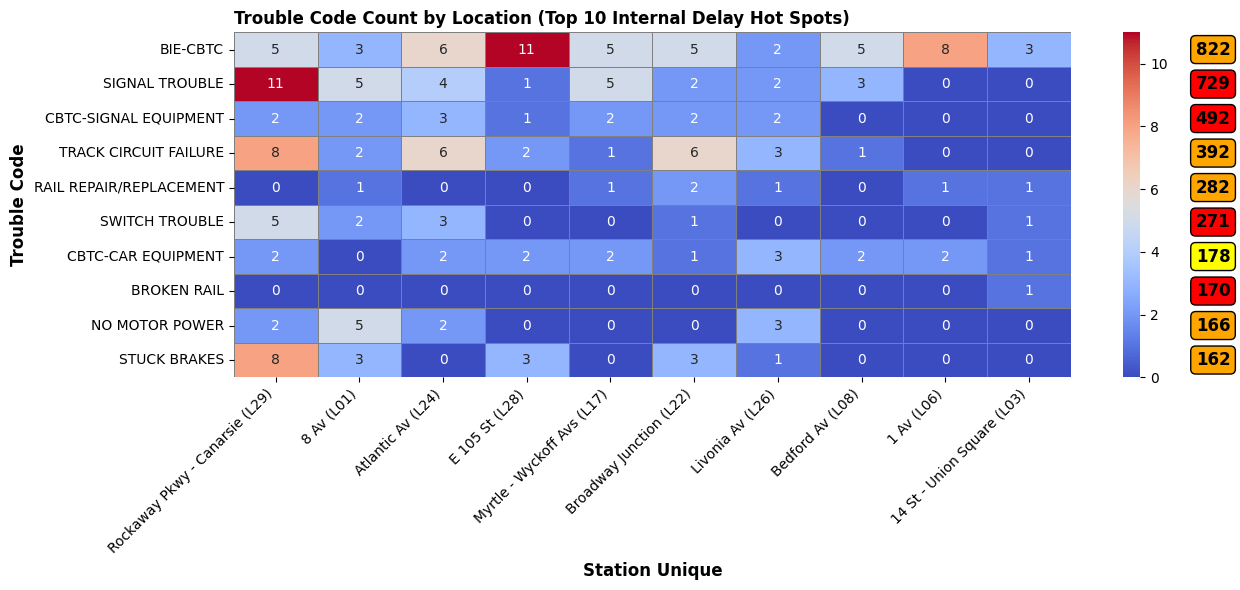

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# === 0. Filter for Internal Delays Only ===
internal_data = data[data['Delay Type'] == 'Internal']

# === 1. Group by Station and Trouble Code ===
grouped_data = internal_data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# === 2. Identify Top 10 Stations by Total Trouble Count ===
top_stations = grouped_data.sum(axis=1).nlargest(10).index
filtered_data = grouped_data.loc[top_stations]

# === 3. Trouble Code Delay Summary ===
trouble_code_summary = internal_data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# === 4. Weighted Delay Ratio + Z-Score ===
alpha = 2
trouble_code_summary['Weighted_Delay_Ratio'] = trouble_code_summary['Delay_Total'] / (trouble_code_summary['Trouble_Count'] + alpha)
trouble_code_summary['Log_Weighted_Ratio'] = np.log1p(trouble_code_summary['Weighted_Delay_Ratio'])
trouble_code_summary['Z_Score'] = (
    trouble_code_summary['Log_Weighted_Ratio'] - trouble_code_summary['Log_Weighted_Ratio'].mean()
) / trouble_code_summary['Log_Weighted_Ratio'].std()

# === 5. Z-Score Color Classification ===
def classify_delay(z_value):
    if z_value <= -0.5:
        return '#abd9e9'
    elif z_value <= 0.5:
        return 'yellow'
    elif z_value <= 1.5:
        return 'orange'
    else:
        return 'red'

# === 6. Filter for Top 10 Trouble Codes by Delay Total ===
top_trouble_codes = trouble_code_summary.nlargest(10, 'Delay_Total')['Trouble Code']
filtered_data = filtered_data[top_trouble_codes]

# === 7. Match Delay Totals + Classify ===
total_delays = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Z_Score']
delay_colors = [classify_delay(val) for val in total_delays]

# === DEBUGGING: Print Matrix for Heatmap ===
print("\n=== Heatmap Matrix (Counts) ===")
print(filtered_data)

print("\n=== Trouble Code Delay Totals and Z-Score Colors ===")
for i, code in enumerate(top_trouble_codes):
    delay = int(trouble_code_summary.set_index('Trouble Code').loc[code, 'Delay_Total'])
    z = round(total_delays[code], 2)
    color = delay_colors[i]
    print(f"{code}: Total Delay = {delay}, Z-Score = {z}, Color = {color}")

# === 8. Append Total Delay Column for Annotation Use ===
filtered_data['Total Delay'] = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Delay_Total'].values

# === 9. Plot ===
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(
    filtered_data.iloc[:, :-1].T,
    cmap="coolwarm",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# === 10. Annotate Delay Totals per Trouble Code with Color ===
for i, (trouble_code, delay) in enumerate(total_delays.items()):
    ax.text(
        len(top_stations) + 1.7, i + 0.5,
        f"{int(trouble_code_summary.set_index('Trouble Code').loc[trouble_code, 'Delay_Total'])}",
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(facecolor=delay_colors[i], edgecolor='black', boxstyle='round,pad=0.3')
    )

# === 11. Labeling ===
plt.title('Trouble Code Count by Location (Top 10 Internal Delay Hot Spots)', fontsize=12, fontweight='bold', loc='left')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


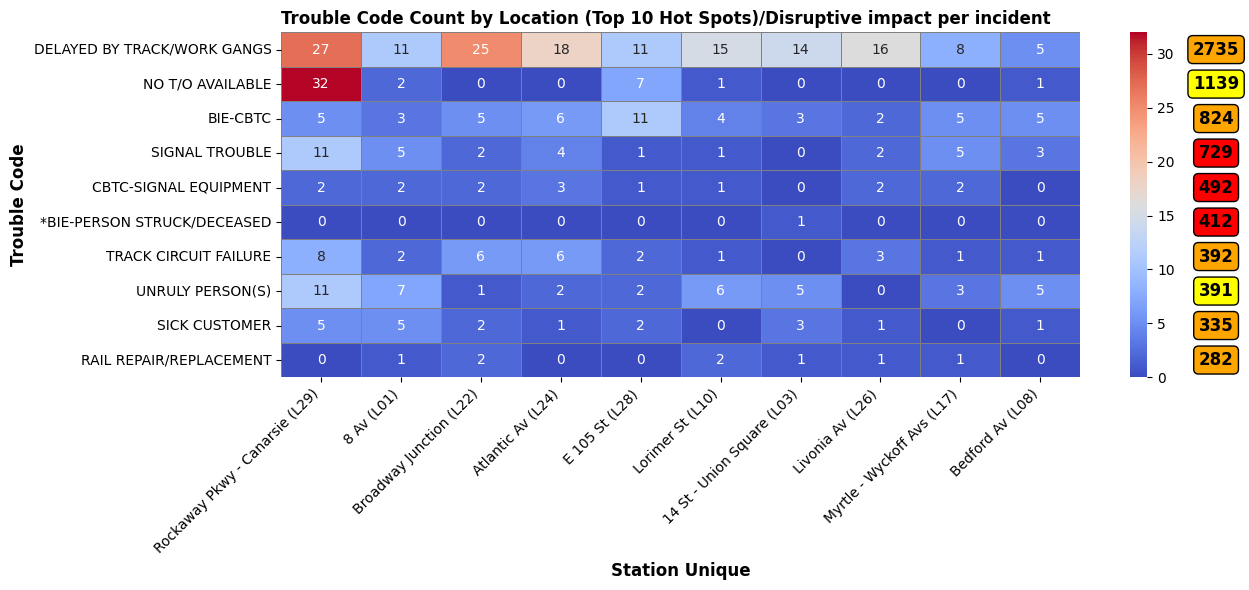

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# Group by 'Station Unique' and 'Trouble Code' and count occurrences
grouped_data = data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# Identify the **top 10 stations** with the highest total delays
top_stations = grouped_data.sum(axis=1).nlargest(10).index

# Filter data for only the **top 10 stations**
filtered_data = grouped_data.loc[top_stations]

# Group by 'Trouble Code' to calculate **sum of 'Delay Total'** and **count of occurrences**
trouble_code_summary = data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# Compute **Weighted Delay Ratio** to penalize rare trouble codes
alpha = 2  # Penalty factor for low-frequency issues
trouble_code_summary['Weighted_Delay_Ratio'] = trouble_code_summary['Delay_Total'] / (trouble_code_summary['Trouble_Count'] + alpha)

# **Log Transformation & Normalization**
trouble_code_summary['Log_Weighted_Ratio'] = np.log1p(trouble_code_summary['Weighted_Delay_Ratio'])

# Compute Z-scores for Weighted Delay Ratio
trouble_code_summary['Z_Score'] = (trouble_code_summary['Log_Weighted_Ratio'] -
                                   trouble_code_summary['Log_Weighted_Ratio'].mean()) / \
                                   trouble_code_summary['Log_Weighted_Ratio'].std()

# **Z-score classification for impact**
def classify_delay(z_value):
    if z_value <= -0.5:
        return '#abd9e9'  # Deep Blue (Lowest Impact)
    elif z_value <= 0.5:
        return 'yellow'  # Light Cyan (Low-Moderate Impact)
    elif z_value <= 1.5:
        return 'orange'  # Bright Yellow (Moderate-High Impact)
    else:
        return 'red'  # Deep Red (Highest Impact)

# Select **top 10 trouble codes** based on **Total Delay**
top_trouble_codes = trouble_code_summary.nlargest(10, 'Delay_Total')['Trouble Code']
filtered_data = filtered_data[top_trouble_codes]

# Apply classification based on Z-score adjusted impact
total_delays = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Z_Score']
delay_colors = [classify_delay(val) for val in total_delays]

# Append total delays as the last column
filtered_data['Total Delay'] = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Delay_Total'].values

# **Plot the heatmap**
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(filtered_data.iloc[:, :-1].T, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, linecolor='gray', ax=ax)

# Annotate total delays with **Z-score intensity colors**
for i, (trouble_code, delay) in enumerate(total_delays.items()):
    ax.text(len(top_stations) + 1.7, i + 0.5, f"{int(trouble_code_summary.set_index('Trouble Code').loc[trouble_code, 'Delay_Total'])}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor=delay_colors[i], edgecolor='black', boxstyle='round,pad=0.3'))

# Customize labels and title
plt.title('Trouble Code Count by Location (Top 10 Hot Spots)/Disruptive impact per incident', fontsize=12, fontweight='bold', loc='left')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



=== Heatmap Matrix (Counts) ===
Trouble Code                    DELAYED BY TRACK/WORK GANGS  NO T/O AVAILABLE  \
Station Unique                                                                  
Rockaway Pkwy - Canarsie (L29)                           27                32   
8 Av (L01)                                               11                 2   
Broadway Junction (L22)                                  25                 0   
Atlantic Av (L24)                                        18                 0   
E 105 St (L28)                                           11                 7   
Lorimer St (L10)                                         15                 1   
14 St - Union Square (L03)                               14                 0   
Livonia Av (L26)                                         16                 0   
Myrtle - Wyckoff Avs (L17)                                8                 0   
Bedford Av (L08)                                          5                 

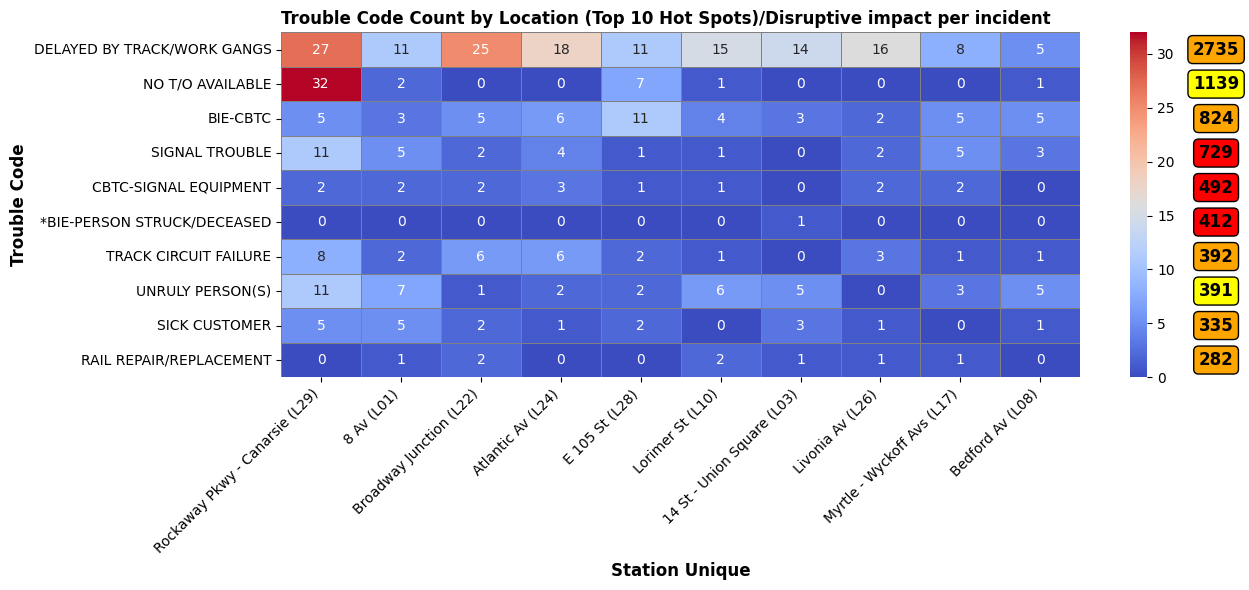

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

# === 1. Group by Station and Trouble Code ===
grouped_data = data.groupby(['Station Unique', 'Trouble Code'])['Trouble Code'].count().unstack(fill_value=0)

# === 2. Identify Top 10 Stations by Total Trouble Count ===
top_stations = grouped_data.sum(axis=1).nlargest(10).index
filtered_data = grouped_data.loc[top_stations]

# === 3. Trouble Code Delay Summary ===
trouble_code_summary = data.groupby('Trouble Code').agg(
    Delay_Total=('Delay Total', 'sum'),
    Trouble_Count=('Trouble Code', 'count')
).reset_index()

# === 4. Weighted Delay Ratio + Z-Score ===
alpha = 2
trouble_code_summary['Weighted_Delay_Ratio'] = trouble_code_summary['Delay_Total'] / (trouble_code_summary['Trouble_Count'] + alpha)
trouble_code_summary['Log_Weighted_Ratio'] = np.log1p(trouble_code_summary['Weighted_Delay_Ratio'])
trouble_code_summary['Z_Score'] = (
    trouble_code_summary['Log_Weighted_Ratio'] - trouble_code_summary['Log_Weighted_Ratio'].mean()
) / trouble_code_summary['Log_Weighted_Ratio'].std()

# === 5. Z-Score Color Classification ===
def classify_delay(z_value):
    if z_value <= -0.5:
        return '#abd9e9'
    elif z_value <= 0.5:
        return 'yellow'
    elif z_value <= 1.5:
        return 'orange'
    else:
        return 'red'

# === 6. Filter for Top 10 Trouble Codes by Delay Total ===
top_trouble_codes = trouble_code_summary.nlargest(10, 'Delay_Total')['Trouble Code']
filtered_data = filtered_data[top_trouble_codes]

# === 7. Match Delay Totals + Classify ===
total_delays = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Z_Score']
delay_colors = [classify_delay(val) for val in total_delays]

# === DEBUGGING: Print Matrix for Heatmap ===
print("\n=== Heatmap Matrix (Counts) ===")
print(filtered_data)

print("\n=== Trouble Code Delay Totals and Z-Score Colors ===")
for i, code in enumerate(top_trouble_codes):
    delay = int(trouble_code_summary.set_index('Trouble Code').loc[code, 'Delay_Total'])
    z = round(total_delays[code], 2)
    color = delay_colors[i]
    print(f"{code}: Total Delay = {delay}, Z-Score = {z}, Color = {color}")

# === 8. Append Total Delay Column for Annotation Use ===
filtered_data['Total Delay'] = trouble_code_summary.set_index('Trouble Code').loc[top_trouble_codes, 'Delay_Total'].values

# === 9. Plot ===
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(
    filtered_data.iloc[:, :-1].T,
    cmap="coolwarm",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# === 10. Annotate Delay Totals per Trouble Code with Color ===
for i, (trouble_code, delay) in enumerate(total_delays.items()):
    ax.text(
        len(top_stations) + 1.7, i + 0.5,
        f"{int(trouble_code_summary.set_index('Trouble Code').loc[trouble_code, 'Delay_Total'])}",
        ha='center',
        va='center',
        fontsize=12,
        fontweight='bold',
        bbox=dict(facecolor=delay_colors[i], edgecolor='black', boxstyle='round,pad=0.3')
    )

# === 11. Labeling ===
plt.title('Trouble Code Count by Location (Top 10 Hot Spots)/Disruptive impact per incident', fontsize=12, fontweight='bold', loc='left')
plt.xlabel('Station Unique', fontsize=12, fontweight='bold')
plt.ylabel('Trouble Code', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
